In [ ]:
!pip install tensorflow_federated
!pip install attention

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from attention import Attention
import keras
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import collections
import random
import time
import math
import os

In [ ]:
def create_fl_clients(data, target, no_of_clients):
    '''
    data - pandas dataframe
    clients - number of FL clients to split the data
    '''
    datasets = []
    for cid in range(no_of_clients):
        #creating a partition value as per the number of FL clients
        partition_size = math.floor(len(data) / no_of_clients)
        #creating indexes to subset the dataframe
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        #subsetting dataframe
        train_batch = data[idx_from:idx_to]
        target_batch = target[idx_from:idx_to]

        dataset = tf.data.Dataset.from_tensor_slices((train_batch, target_batch)).batch(1)
        datasets.append(dataset)

    return datasets

In [ ]:
def model_fn():
    model = create_model_fn()
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(2)
    input_spec = dataset.element_spec
    return tff.learning.models.from_keras_model(
      model,
      input_spec = input_spec,
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
import time
import datetime

now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def train(trainer, train_data, val_data, num_rounds, no_of_clients, fit_on):
    train_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR)

    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    #we want to set the federated learning params to be set to default
    state = trainer.initialize()
    #create model for evaluation
    eval = tff.learning.build_federated_evaluation(model_fn)
    return_state = None
    best_loss = None
    #for plotting we declare arrays
    train_acc = []
    train_mse = []
    train_loss = []
    eval_acc = []
    eval_mse = []
    eval_loss = []

    # test_acc = []
    # test_loss = []
    for n in range(num_rounds):
        t1 = time.time()
        print("Training...")
        #passing the new state with randomly chosen training dataset
        result = trainer.next(state, train_data)
        #setting new state for trained parameters
        state = result.state
        #declaring taining metrics
        train_metrics = result.metrics['client_work']['train']
        print("Evaluating...")
        #using learning algorithm we pass the currrent state of round for evaluation
        eval_metrics = eval(trainer.get_model_weights(state), [val_data])
        eval_metrics = eval_metrics['eval']
        print("Done...")
        t2 = time.time()
        print('Round:{a} Train - RMSE:{m:.4f} MAE:{x:.4f}, Loss:{t:.4f} | Eval - RMSE:{b:.4f} MAE:{d:.4f}, Loss:{c:.4f} | Time - {f:.2f}'.format(
              a=n+1,
              m=train_metrics['root_mean_squared_error'],
              x=train_metrics['mean_absolute_error'],
              t=train_metrics['loss'],
              b=eval_metrics['root_mean_squared_error'],
              d=eval_metrics['mean_absolute_error'],
              c=eval_metrics['loss'],
              # d=test_metrics['root_mean_squared_error'],
              # e=test_metrics['loss']
              f=t2-t1
        ))

        #early stopping
        if(best_loss != None and eval_metrics['loss'] >= best_loss):
          print("LOSS DID NOT IMPROVE...")
        else:
          print("Loss improved!")
          return_state = result.state
          best_loss = eval_metrics['loss']
          print("Saving model state...")

        #assigning metrics for plotting purposes
        train_acc.append(train_metrics['root_mean_squared_error'])
        train_mse.append(train_metrics['mean_absolute_error'])
        train_loss.append(train_metrics['loss'])

        eval_acc.append(eval_metrics['root_mean_squared_error'])
        eval_mse.append(eval_metrics['mean_absolute_error'])
        eval_loss.append(eval_metrics['loss'])

        with train_summary_writer.as_default():
          tf.summary.scalar("training/rmse", train_metrics['root_mean_squared_error'], step=n+1)
          tf.summary.scalar("training/mse", train_metrics['mean_absolute_error'], step=n+1)

          tf.summary.scalar("validation/rmse", eval_metrics['root_mean_squared_error'], step=n+1)
          tf.summary.scalar("validation/mse", eval_metrics['mean_absolute_error'], step=n+1)

        #using learning algorithm we pass the currrent state of round for testing
        # test_metrics = eval(trainer.get_model_weights(state), [test_client_data])
        # test_metrics = test_metrics['eval']




    return return_state, train_acc, train_mse, train_loss, eval_acc, eval_mse, eval_loss

In [ ]:
import matplotlib
def plot(train_acc, train_mse, train_loss, eval_acc, eval_mse, eval_loss):
  plt.figure(figsize=(16, 6))
  plt.plot(train_acc, label="Training RMSE")
  plt.plot(eval_acc, label="Evaluation RMSE")
  plt.title("RMSE using past " + str(past) + " hours to predict next 1 hour (LR:" + str(SERVER_LR)+ ")")
  plt.xlabel("Rounds")
  plt.ylabel("RMSE")
  plt.legend()
  # plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

  plt.figure(figsize=(16, 6))
  plt.plot(train_mse, label="Training MAE")
  plt.plot(eval_mse, label="Evaluation MAE")
  plt.title("MAE using past " + str(past) + " hours to predict next 1 hour (LR:" + str(SERVER_LR)+ ")")
  plt.xlabel("Rounds")
  plt.ylabel("MAE")
  plt.legend()
  # plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

In [ ]:
def normalize(data):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std
    # scaler = MinMaxScaler(feature_range=(0,1))
    # transformed = scaler.fit_transform(data)
    # return transformed, scaler

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
data = pd.read_csv('../data/davitt_road.csv')
#dropping uncessary columns
data = data.drop(['Unnamed: 0'], axis=1)

split_fraction = 0.80
train_split = int(split_fraction * int(data.shape[0]))
step = 1

past = 2 #past 7 days (7*24=168 hours)
future = 1 #using past 168 steps predict next 24 steps (24 hours)

In [ ]:
features = data[["temp", "wetb", "dewpt", "vappr", "pm10"]]
features.index = data["datetime"]
feature_columns = features.columns
#print(features.head())

targets = data[["pm2.5"]]
targets_columns = targets.columns

features = normalize(features.values)
#targets = scaler.transform(targets.values)

features_df = pd.DataFrame(features, columns = feature_columns)
#targets = pd.DataFrame(targets, columns = targets_columns)

input_size = len(features_df.columns)

x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                   train_split, past,
                                                   future, step)
x_val, y_val = multivariate_data(features_df.values, targets["pm2.5"].values,
                                               train_split, None, past,
                                               future, step)

In [ ]:
def create_model_fn():
  input = keras.layers.Input(shape=(past, input_size))
  layer = keras.layers.Conv1D(filters=15, kernel_size=2, padding="same", activation="relu")(input)
  layer = tf.keras.layers.MaxPooling1D(pool_size=2)(layer)
  layer = keras.layers.Conv1D(filters=12, kernel_size=2, padding="same", activation="relu")(layer)
  layer = tf.keras.layers.LSTM(32, return_sequences=True)(layer)
  layer = Attention(units=10)(layer)
  output = keras.layers.Dense(future)(layer)

  model = keras.Model(inputs=input, outputs=output)
  return model

In [ ]:
#setting number of clients
NUM_CLIENTS = 2
NUM_FIT = 5
ROUNDS = 100

In [ ]:
def optimizers(SERVER_LR, CLIENT_LR):
  server_optimizer_fn=lambda: tf.keras.optimizers.SGD(SERVER_LR, momentum=0.9)
  client_optimizer_fn=lambda: tf.keras.optimizers.SGD(CLIENT_LR, momentum=0.9)

  return server_optimizer_fn, client_optimizer_fn

In [ ]:
train_data = create_fl_clients(x_train, y_train, NUM_CLIENTS)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

In [ ]:
SERVER_LR = 0.001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state1, train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-6-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.8949 MAE:3.7170, Loss:3.7170 | Eval - RMSE:11.1733 MAE:6.9856, Loss:6.9856 | Time - 42.72
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.6213 MAE:3.5188, Loss:3.5188 | Eval - RMSE:10.4825 MAE:6.0484, Loss:6.0484 | Time - 34.96
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.4331 MAE:3.4257, Loss:3.4257 | Eval - RMSE:9.3603 MAE:4.7156, Loss:4.7156 | Time - 37.23
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:7.1802 MAE:3.2330, Loss:3.2330 | Eval - RMSE:7.9427 MAE:3.4129, Loss:3.4129 | Time - 42.61
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.9776 MAE:3.1472, Loss:3.1472 | Eval - RMSE:6.8461 MAE:2.9068, Loss:2.9068 | Time - 35.14
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:6.7526 MAE:3.0639, Loss:3.06

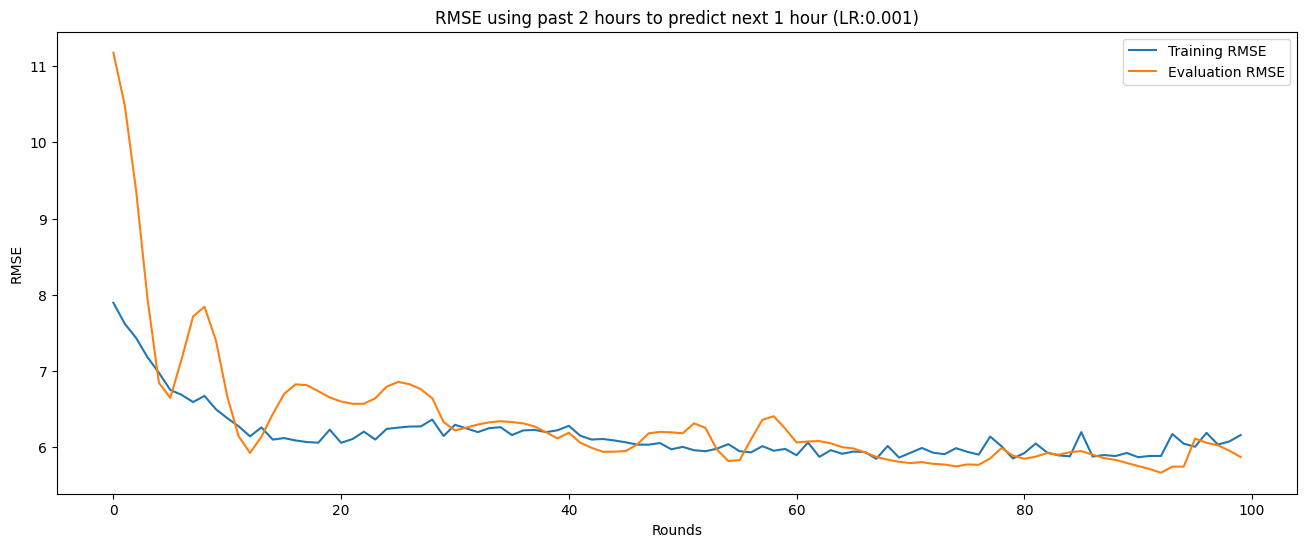

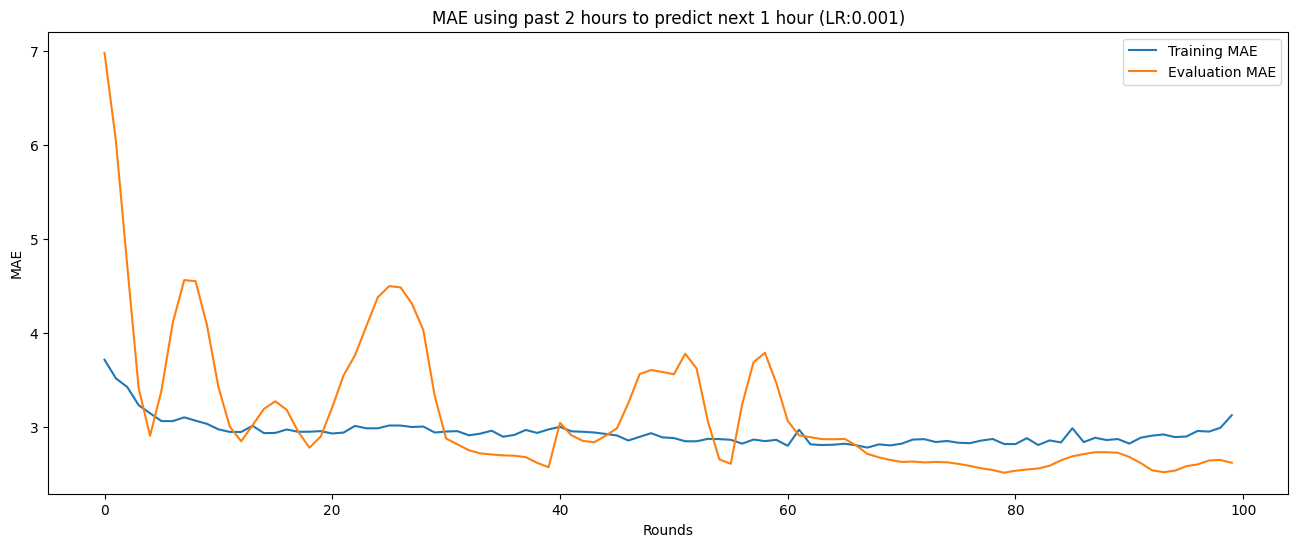

In [ ]:
plot(train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test1 = create_model_fn()
trained_model = trainer.get_model_weights(state1)
trained_model.assign_weights_to(model_test1)


predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test1.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 36ms/step


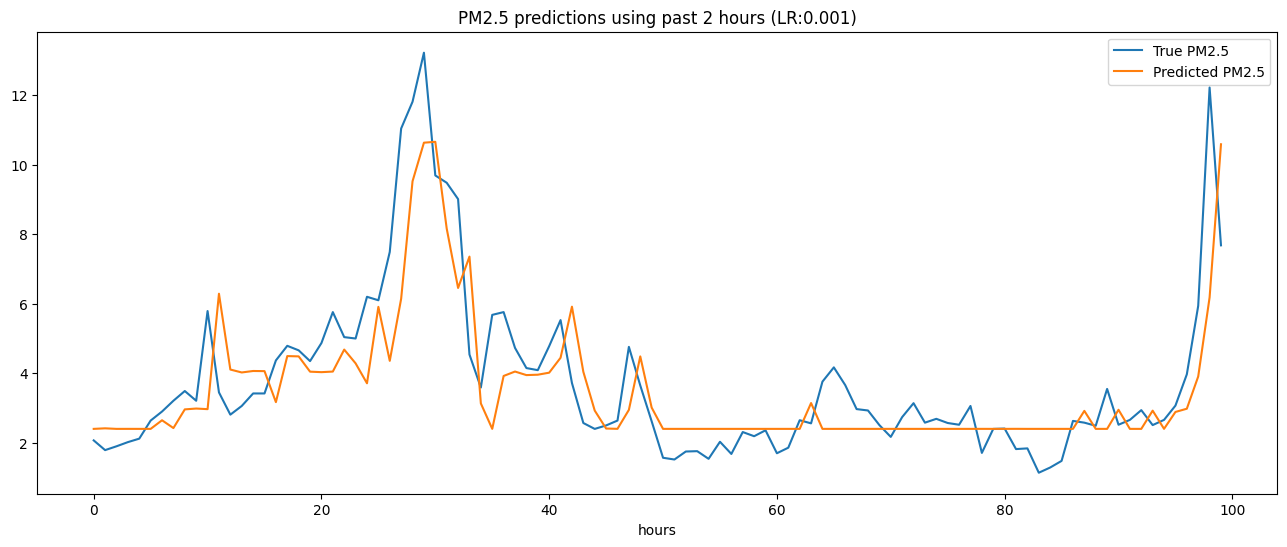

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-6-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:10.4348 MAE:5.5614, Loss:5.5614 | Eval - RMSE:11.3620 MAE:7.2649, Loss:7.2649 | Time - 41.10
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:9.9207 MAE:5.1138, Loss:5.1138 | Eval - RMSE:10.9090 MAE:6.6707, Loss:6.6707 | Time - 40.27
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:9.3072 MAE:4.5612, Loss:4.5612 | Eval - RMSE:10.0299 MAE:5.6347, Loss:5.6347 | Time - 66.97
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:8.7048 MAE:3.9989, Loss:3.9989 | Eval - RMSE:8.7793 MAE:4.1737, Loss:4.1737 | Time - 51.76
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:8.1970 MAE:3.5934, Loss:3.5934 | Eval - RMSE:7.7767 MAE:3.1325, Loss:3.1325 | Time - 60.45
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:7.8798 MAE:3.4067, Loss:3.

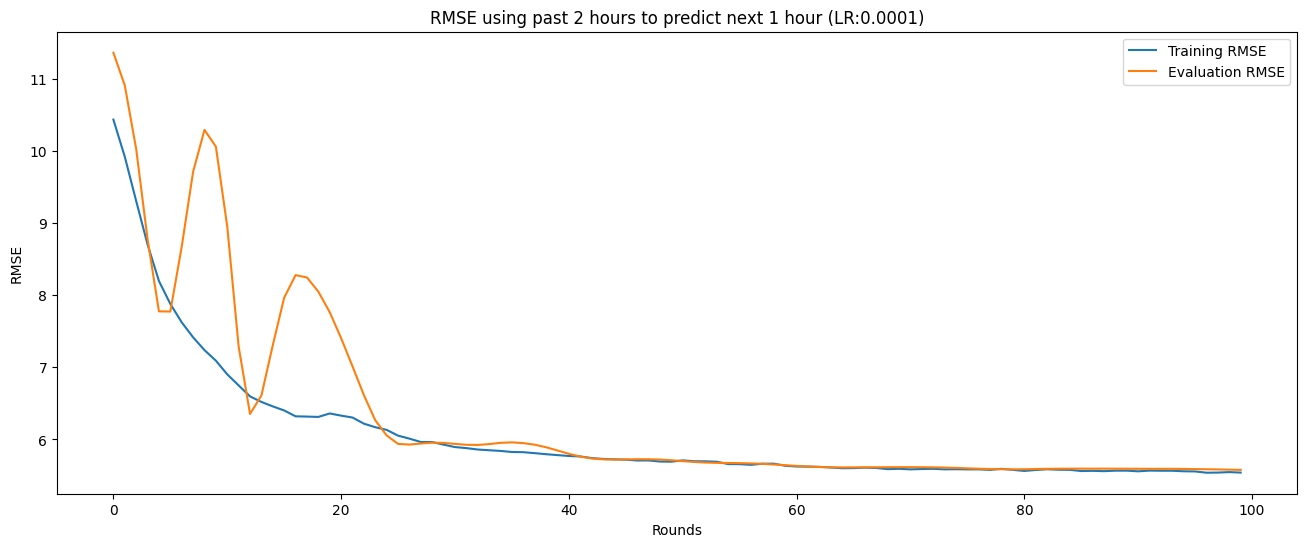

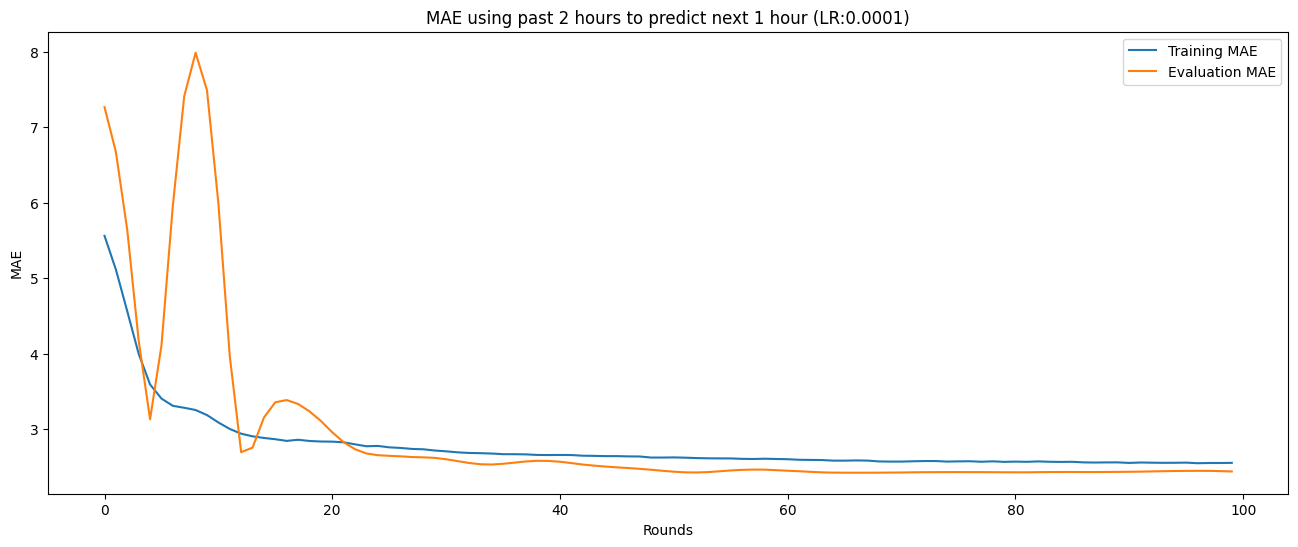

In [ ]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/public_data/past_2')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 36ms/step


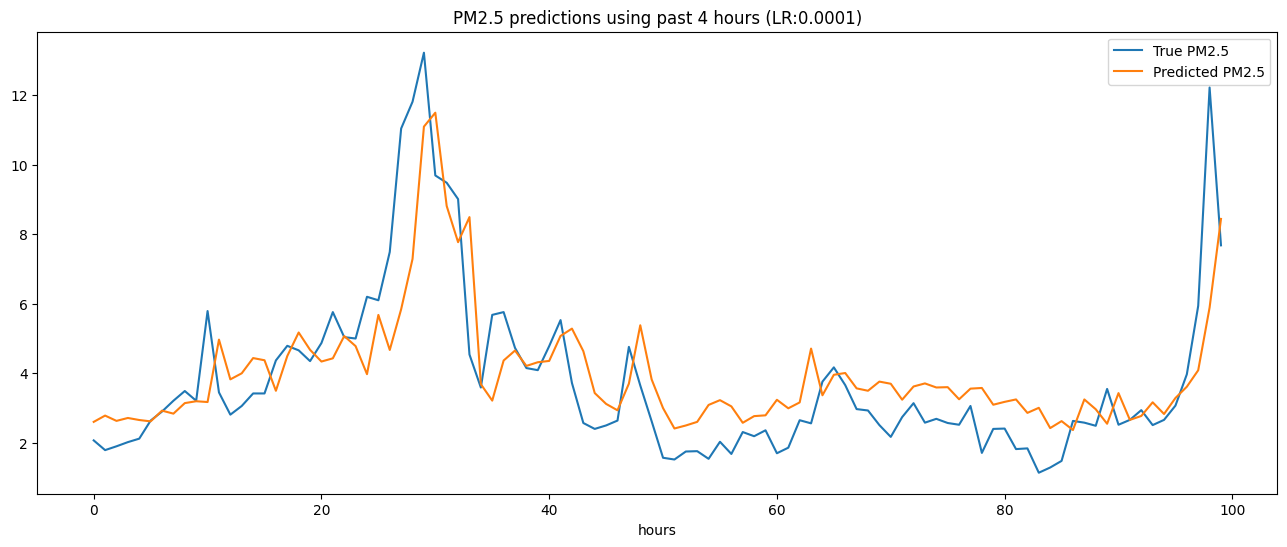

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({
    "Train Clients": [NUM_FIT, NUM_FIT],
    "Epochs": [ROUNDS, ROUNDS],
    "Server LR": ["0.001", "0.0001"],
    "Client LR": [0.1, 0.1],
    "Validation RMSE": [min(eval_acc1), min(eval_acc2)],
    "Validation MAE": [min(eval_mse1), min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.001,0.1,5.667580,2.513953
1,5,100,0.0001,0.1,5.579016,2.424918


## Past 4

In [ ]:
past = 4

x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                   train_split, past,
                                                   future, step)
x_val, y_val = multivariate_data(features_df.values, targets["pm2.5"].values,
                                               train_split, None, past,
                                               future, step)

In [ ]:
train_data = create_fl_clients(x_train, y_train, NUM_CLIENTS)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

In [ ]:
SERVER_LR = 0.001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state1, train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-6-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.9711 MAE:3.7605, Loss:3.7605 | Eval - RMSE:11.1787 MAE:7.0153, Loss:7.0153 | Time - 48.26
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.6725 MAE:3.5619, Loss:3.5619 | Eval - RMSE:10.3351 MAE:5.8797, Loss:5.8797 | Time - 43.08
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.3856 MAE:3.3460, Loss:3.3460 | Eval - RMSE:9.0179 MAE:4.3390, Loss:4.3390 | Time - 49.03
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:7.1198 MAE:3.1906, Loss:3.1906 | Eval - RMSE:7.6481 MAE:3.1693, Loss:3.1693 | Time - 44.86
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.8483 MAE:3.0682, Loss:3.0682 | Eval - RMSE:6.7557 MAE:2.7831, Loss:2.7831 | Time - 43.71
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:6.6727 MAE:3.0028, Loss:3.00

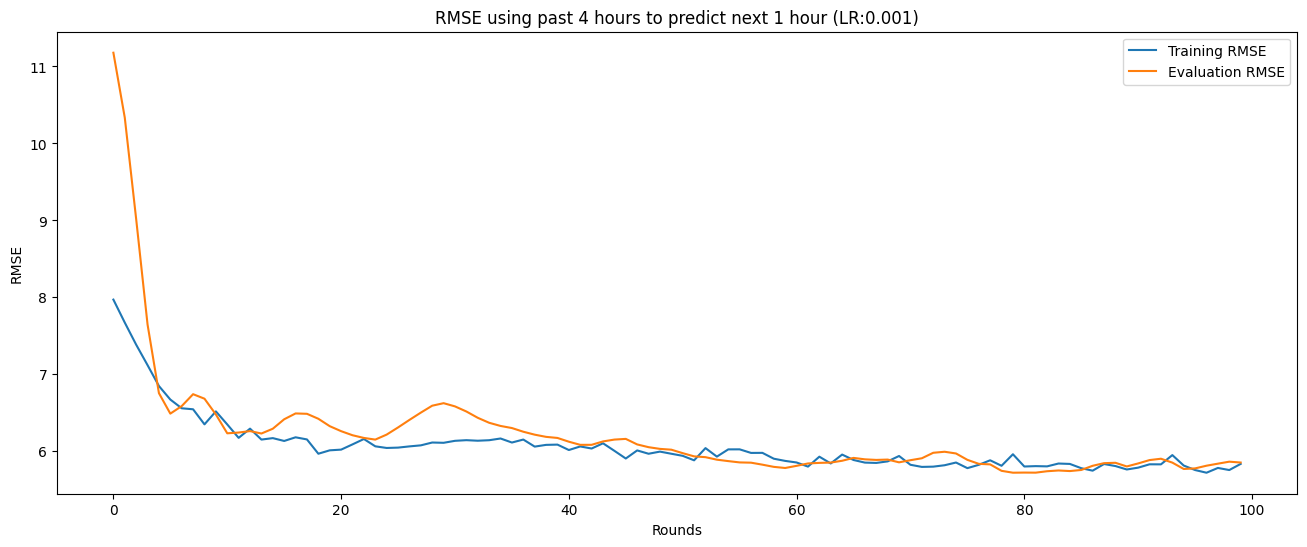

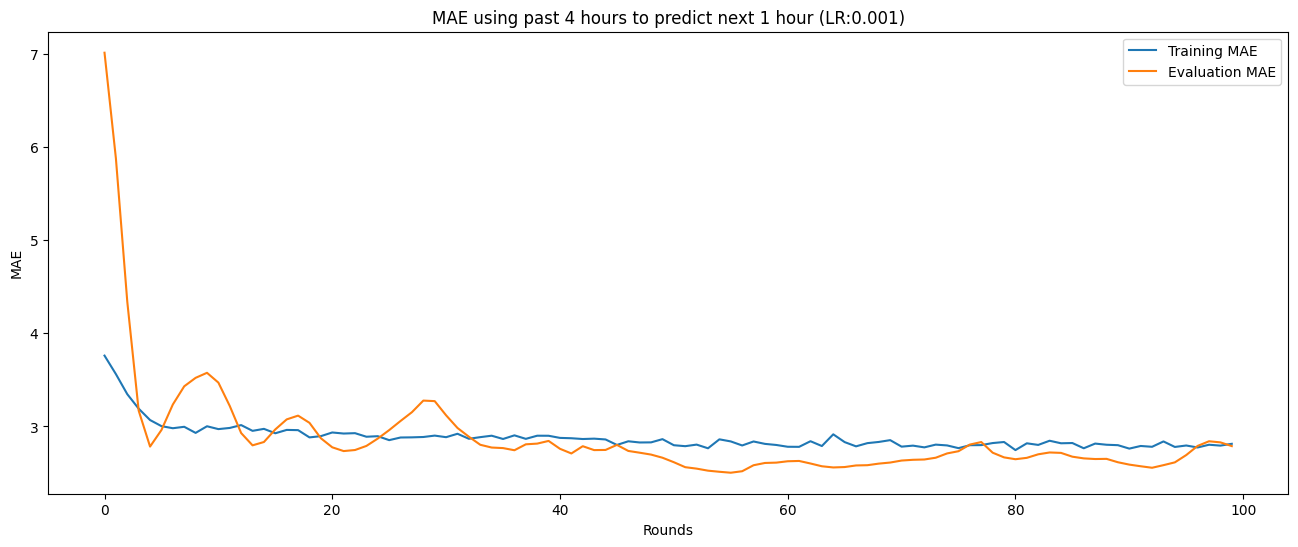

In [ ]:
plot(train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test1 = create_model_fn()
trained_model = trainer.get_model_weights(state1)
trained_model.assign_weights_to(model_test1)


predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test1.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 29ms/step


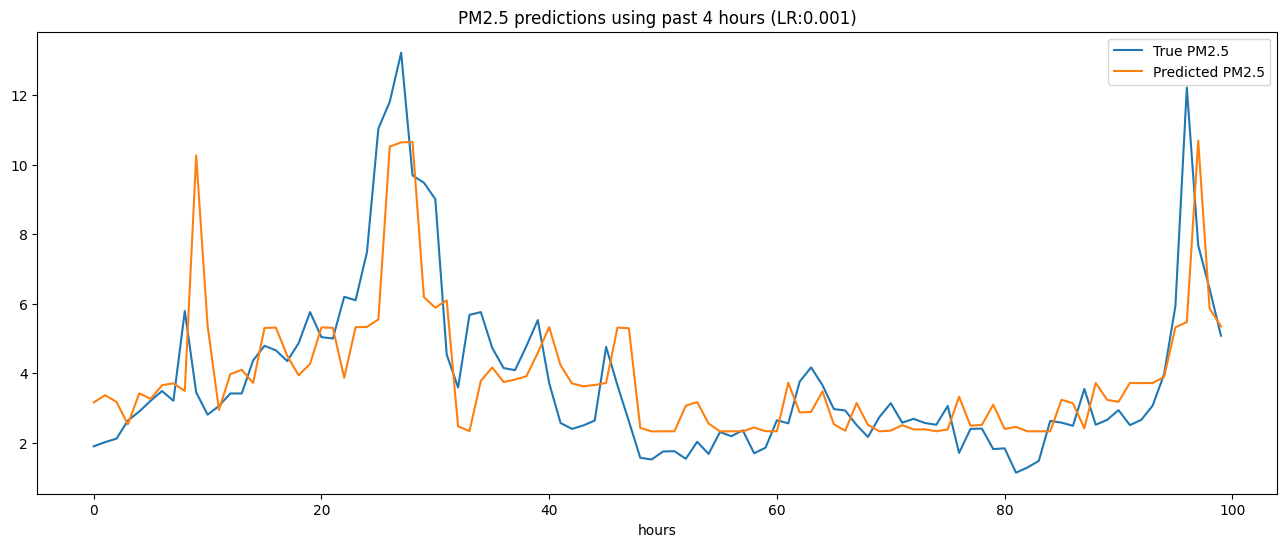

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-6-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:9.8721 MAE:5.1023, Loss:5.1023 | Eval - RMSE:11.2738 MAE:7.1238, Loss:7.1238 | Time - 47.44
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:9.5356 MAE:4.7835, Loss:4.7835 | Eval - RMSE:10.7587 MAE:6.4600, Loss:6.4600 | Time - 43.26
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:9.0491 MAE:4.3297, Loss:4.3297 | Eval - RMSE:9.8338 MAE:5.3766, Loss:5.3766 | Time - 43.15
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:8.5776 MAE:3.9429, Loss:3.9429 | Eval - RMSE:8.6769 MAE:4.0320, Loss:4.0320 | Time - 55.08
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:8.1933 MAE:3.6748, Loss:3.6748 | Eval - RMSE:7.8016 MAE:3.2454, Loss:3.2454 | Time - 44.16
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:7.9144 MAE:3.5181, Loss:3.51

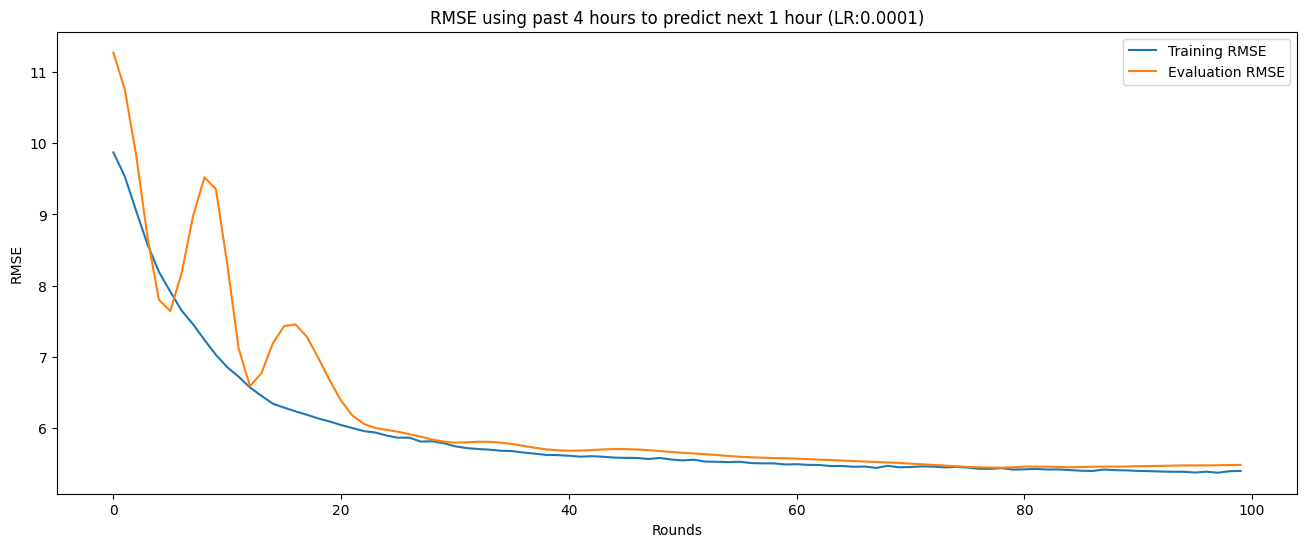

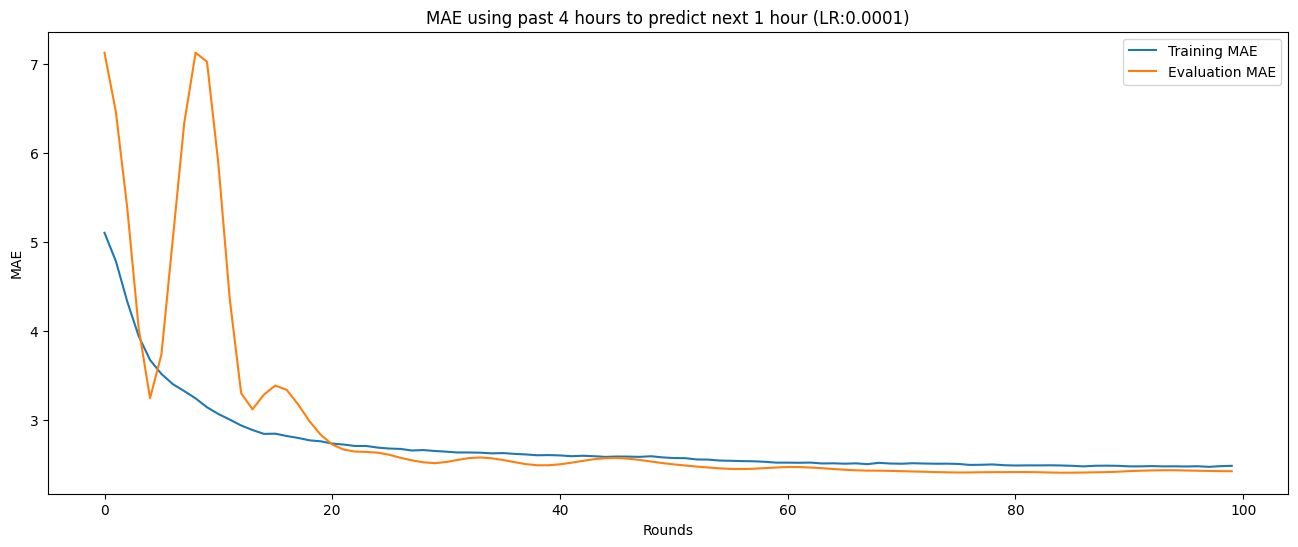

In [ ]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/public_data/past_4')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 25ms/step


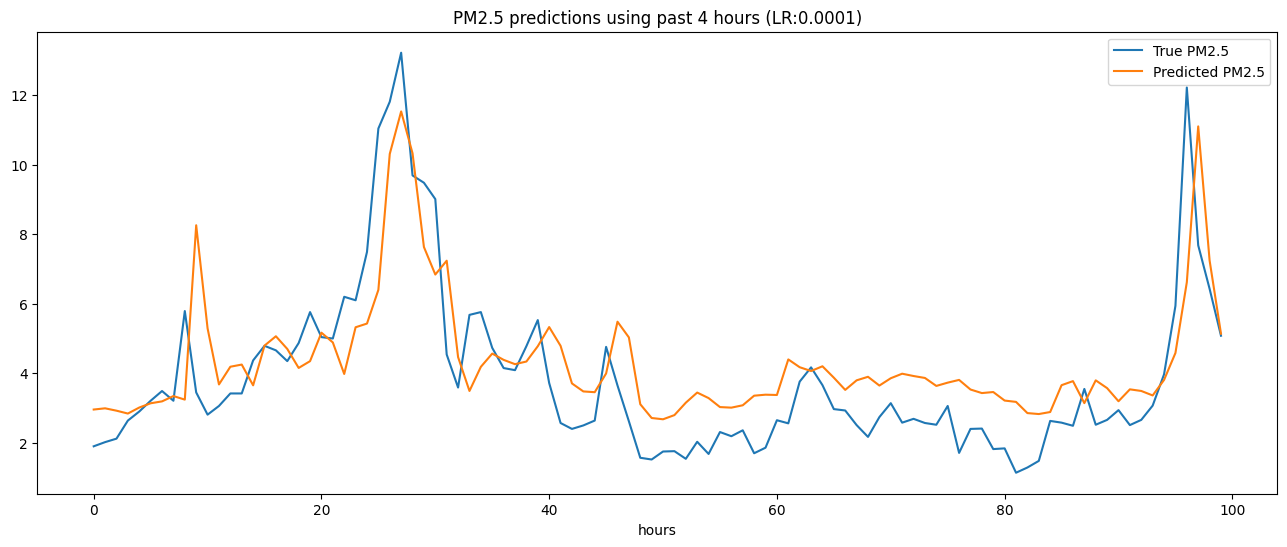

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({
    "Train Clients": [NUM_FIT, NUM_FIT],
    "Epochs": [ROUNDS, ROUNDS],
    "Server LR": ["0.001", "0.0001"],
    "Client LR": [0.1, 0.1],
    "Validation RMSE": [min(eval_acc1), min(eval_acc2)],
    "Validation MAE": [min(eval_mse1), min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.001,0.1,5.722267,2.502183
1,5,100,0.0001,0.1,5.439712,2.409510


# Past 6

In [ ]:
past = 6

x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                   train_split, past,
                                                   future, step)
x_val, y_val = multivariate_data(features_df.values, targets["pm2.5"].values,
                                               train_split, None, past,
                                               future, step)

In [ ]:
train_data = create_fl_clients(x_train, y_train, NUM_CLIENTS)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

In [ ]:
SERVER_LR = 0.001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state1, train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-6-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.8701 MAE:3.7031, Loss:3.7031 | Eval - RMSE:11.0149 MAE:6.8915, Loss:6.8915 | Time - 64.27
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.6488 MAE:3.5860, Loss:3.5860 | Eval - RMSE:10.2434 MAE:5.9460, Loss:5.9460 | Time - 63.20
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.4713 MAE:3.4193, Loss:3.4193 | Eval - RMSE:9.1330 MAE:4.6524, Loss:4.6524 | Time - 49.03
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:7.2172 MAE:3.2748, Loss:3.2748 | Eval - RMSE:7.9279 MAE:3.4602, Loss:3.4602 | Time - 54.21
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:7.0035 MAE:3.1679, Loss:3.1679 | Eval - RMSE:6.9770 MAE:2.9529, Loss:2.9529 | Time - 52.69
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:6.7707 MAE:3.0563, Loss:3.05

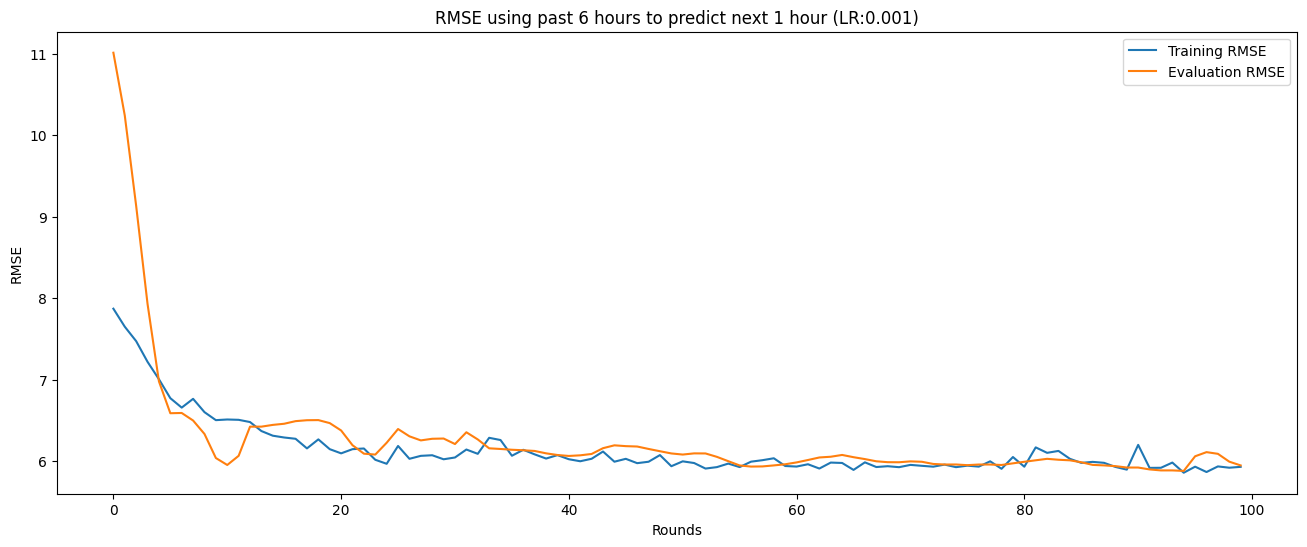

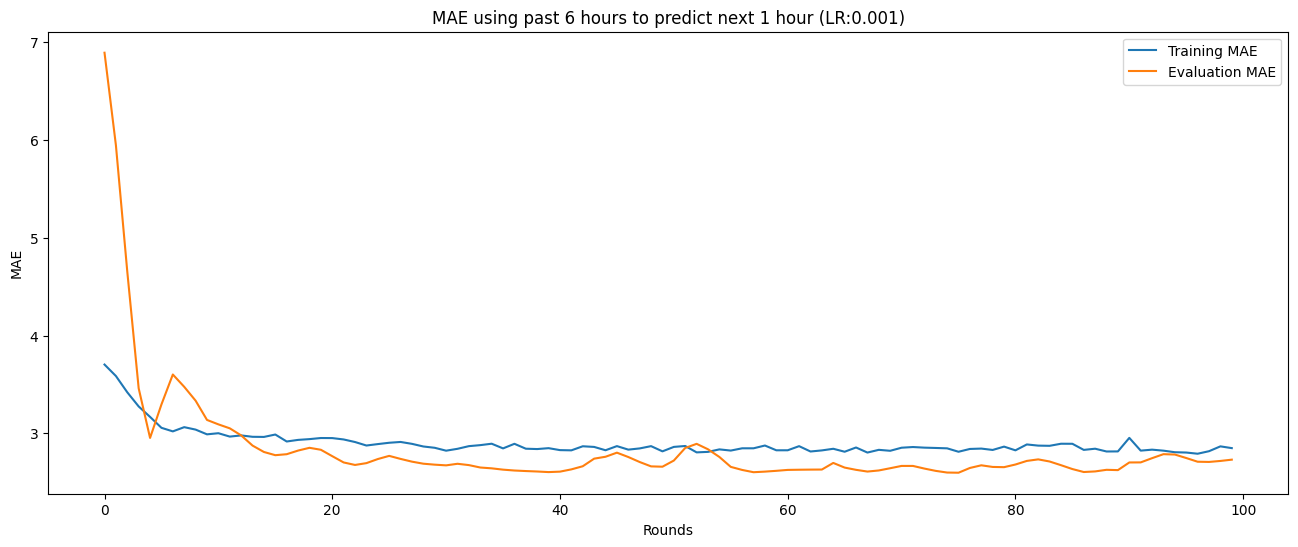

In [ ]:
plot(train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test1 = create_model_fn()
trained_model = trainer.get_model_weights(state1)
trained_model.assign_weights_to(model_test1)


predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test1.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 28ms/step


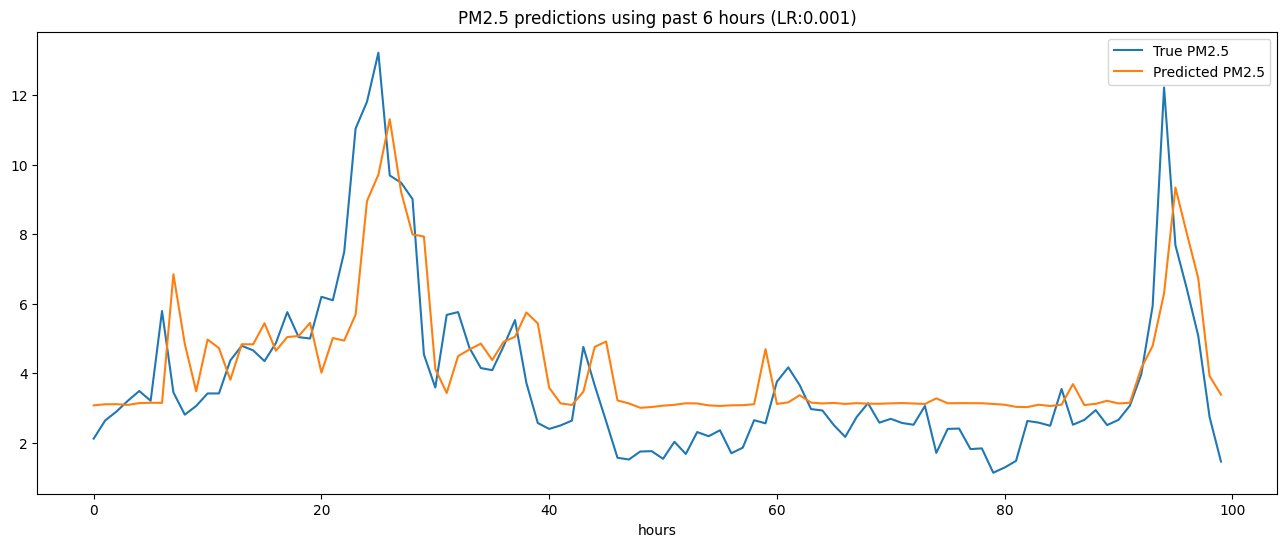

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-6-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:9.5559 MAE:4.8695, Loss:4.8695 | Eval - RMSE:11.3278 MAE:7.3414, Loss:7.3414 | Time - 55.58
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:9.3214 MAE:4.6490, Loss:4.6490 | Eval - RMSE:10.8214 MAE:6.7612, Loss:6.7612 | Time - 49.26
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:8.9745 MAE:4.3108, Loss:4.3108 | Eval - RMSE:9.8933 MAE:5.6725, Loss:5.6725 | Time - 56.23
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:8.5845 MAE:3.9999, Loss:3.9999 | Eval - RMSE:8.7305 MAE:4.2191, Loss:4.2191 | Time - 51.51
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:8.2665 MAE:3.7768, Loss:3.7768 | Eval - RMSE:7.8192 MAE:3.3000, Loss:3.3000 | Time - 52.51
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:7.9975 MAE:3.6011, Loss:3.60

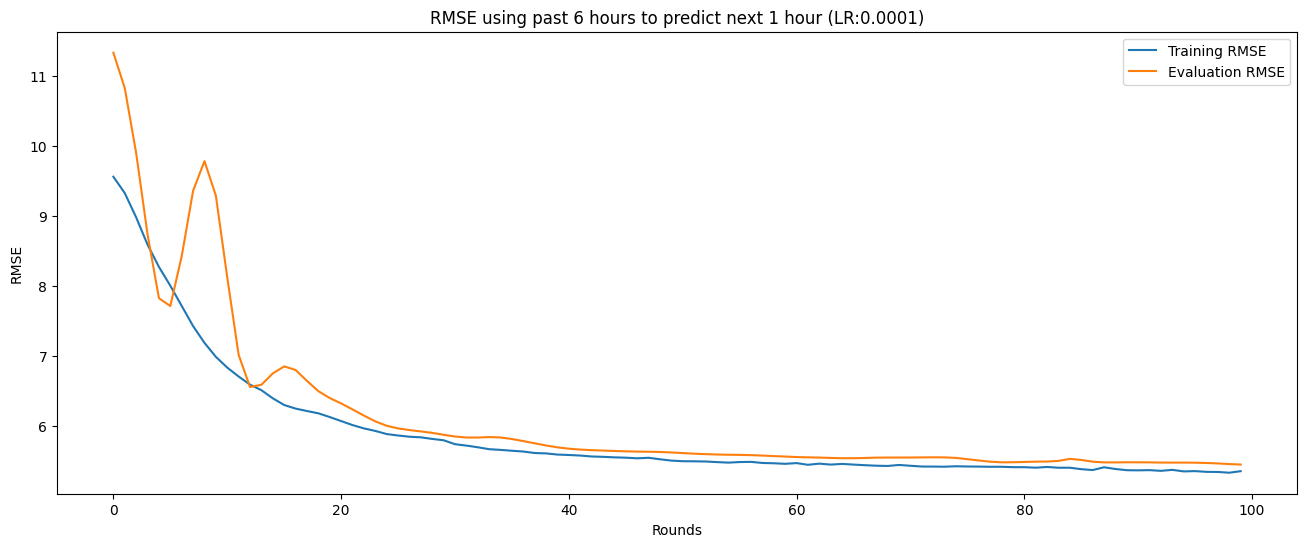

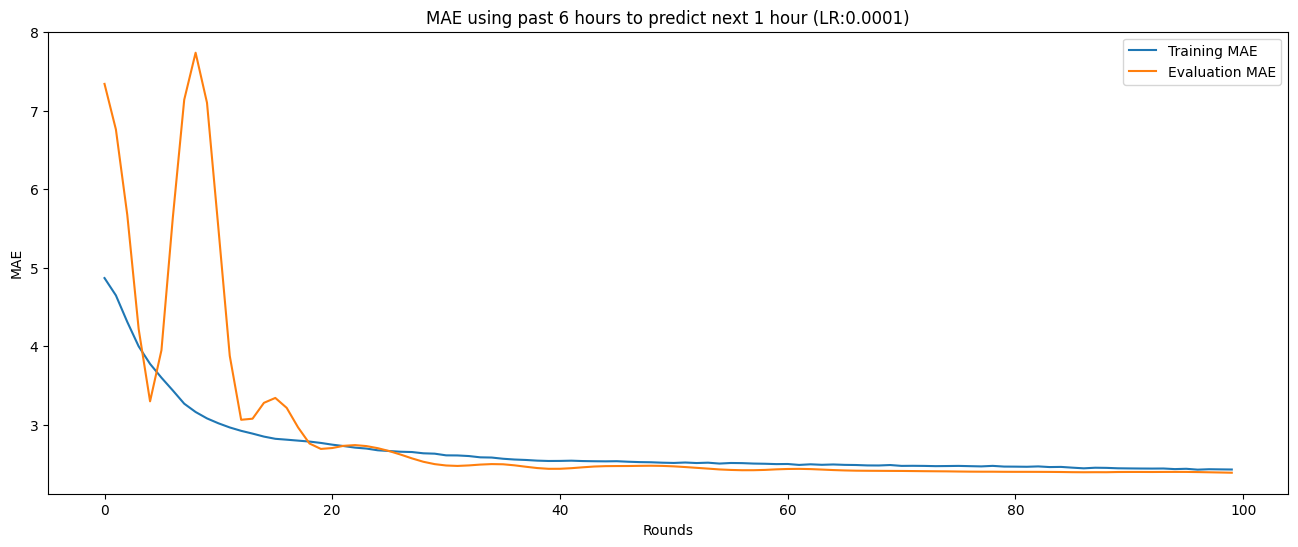

In [ ]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/public_data/past_6')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 97ms/step


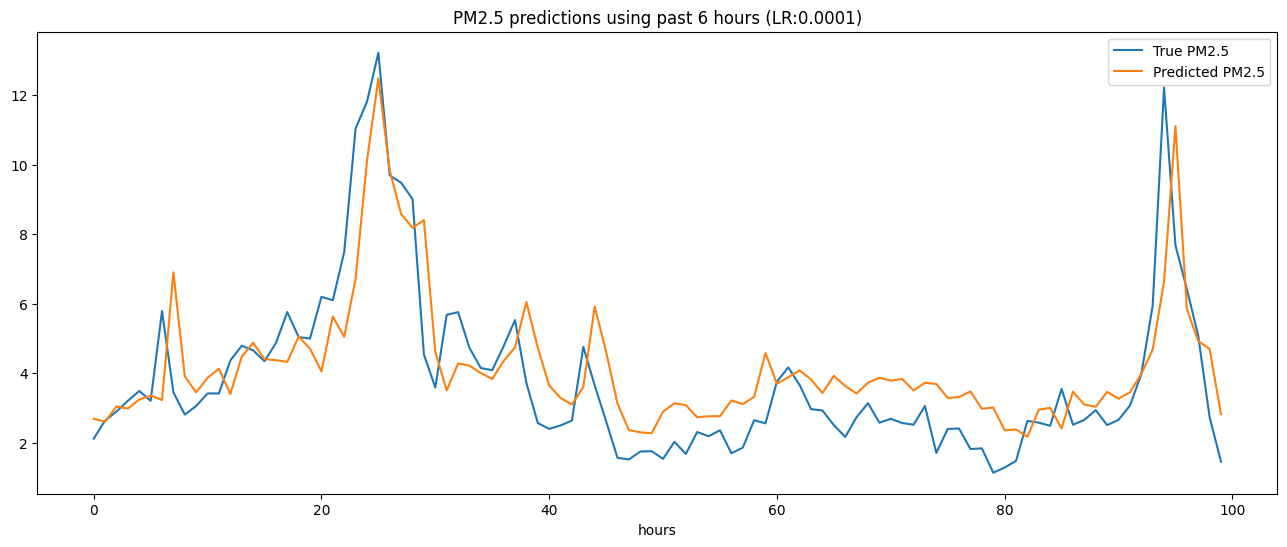

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({
    "Train Clients": [NUM_FIT, NUM_FIT],
    "Epochs": [ROUNDS, ROUNDS],
    "Server LR": ["0.001", "0.0001"],
    "Client LR": [0.1, 0.1],
    "Validation RMSE": [min(eval_acc1), min(eval_acc2)],
    "Validation MAE": [min(eval_mse1), min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.001,0.1,5.877133,2.597136
1,5,100,0.0001,0.1,5.442329,2.391294


# Past 8

In [ ]:
past = 8

x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                   train_split, past,
                                                   future, step)
x_val, y_val = multivariate_data(features_df.values, targets["pm2.5"].values,
                                               train_split, None, past,
                                               future, step)

In [ ]:
train_data = create_fl_clients(x_train, y_train, NUM_CLIENTS)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

In [ ]:
SERVER_LR = 0.001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state1, train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-15-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:8.0203 MAE:3.7877, Loss:3.7877 | Eval - RMSE:11.1956 MAE:7.0206, Loss:7.0206 | Time - 63.40
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.7991 MAE:3.6189, Loss:3.6189 | Eval - RMSE:10.3415 MAE:5.8716, Loss:5.8716 | Time - 49.47
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.4115 MAE:3.3706, Loss:3.3706 | Eval - RMSE:9.0110 MAE:4.3124, Loss:4.3124 | Time - 50.04
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:7.1266 MAE:3.2146, Loss:3.2146 | Eval - RMSE:7.6445 MAE:3.2096, Loss:3.2096 | Time - 50.02
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.8851 MAE:3.0970, Loss:3.0970 | Eval - RMSE:6.7483 MAE:2.8913, Loss:2.8913 | Time - 57.82
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:6.7048 MAE:3.0175, Loss:3.01

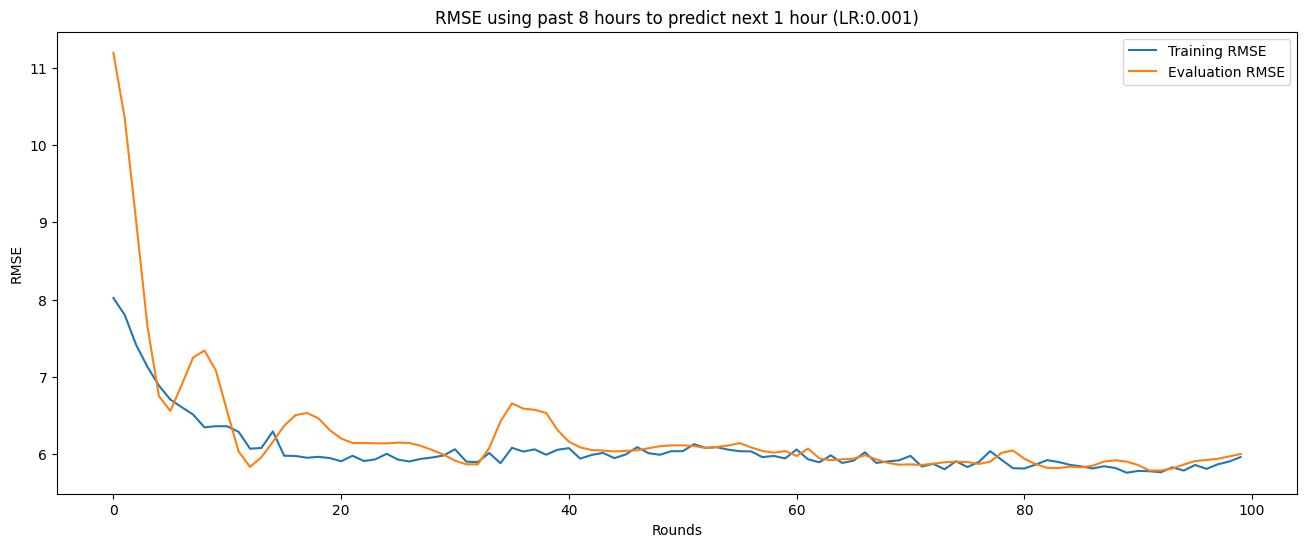

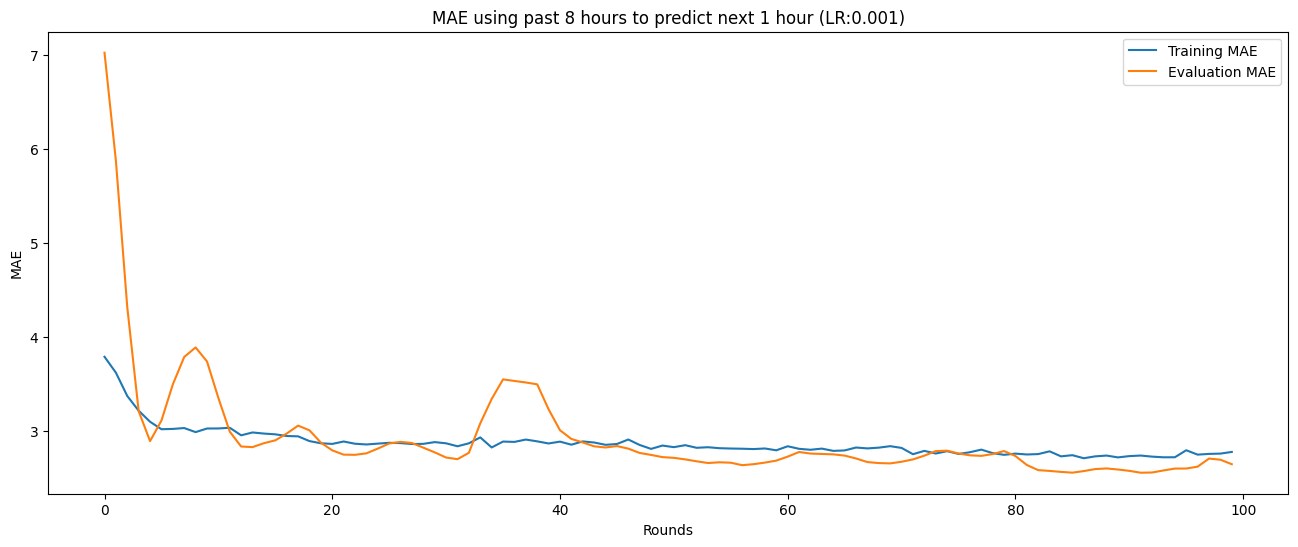

In [ ]:
plot(train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test1 = create_model_fn()
trained_model = trainer.get_model_weights(state1)
trained_model.assign_weights_to(model_test1)


predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test1.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 32ms/step


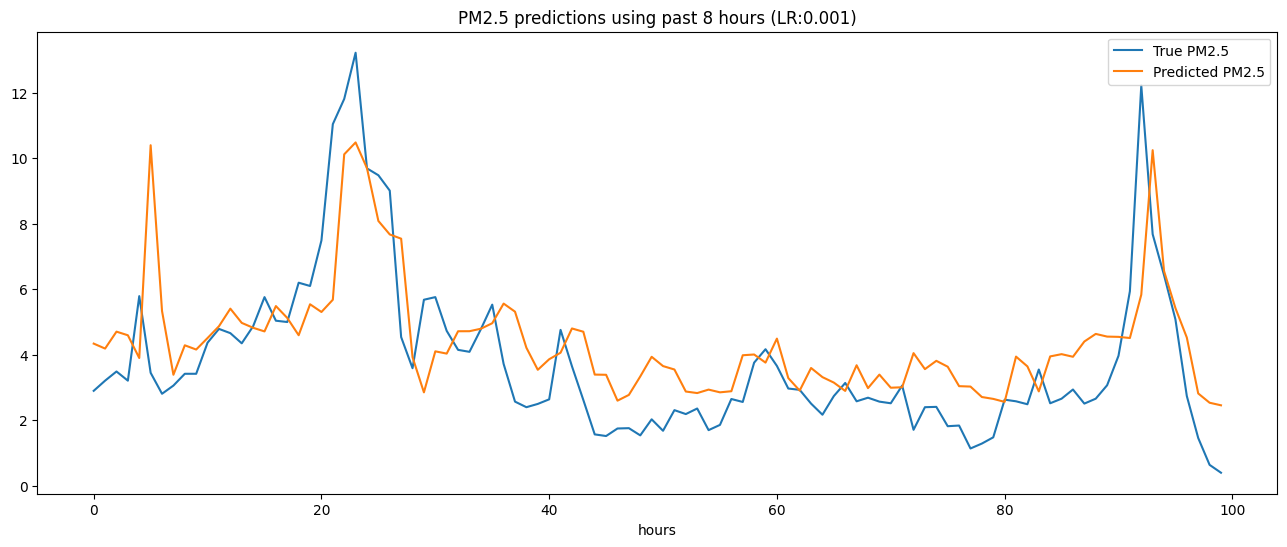

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-15-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:9.2643 MAE:4.6018, Loss:4.6018 | Eval - RMSE:11.2610 MAE:7.1878, Loss:7.1878 | Time - 56.89
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:9.0691 MAE:4.4185, Loss:4.4185 | Eval - RMSE:10.7133 MAE:6.5600, Loss:6.5600 | Time - 49.49
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:8.7580 MAE:4.1590, Loss:4.1590 | Eval - RMSE:9.7345 MAE:5.4428, Loss:5.4428 | Time - 102.70
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:8.4300 MAE:3.9082, Loss:3.9082 | Eval - RMSE:8.5366 MAE:4.0193, Loss:4.0193 | Time - 116.37
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:8.1584 MAE:3.7075, Loss:3.7075 | Eval - RMSE:7.7042 MAE:3.2667, Loss:3.2667 | Time - 50.67
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:7.8553 MAE:3.4912, Loss:3.

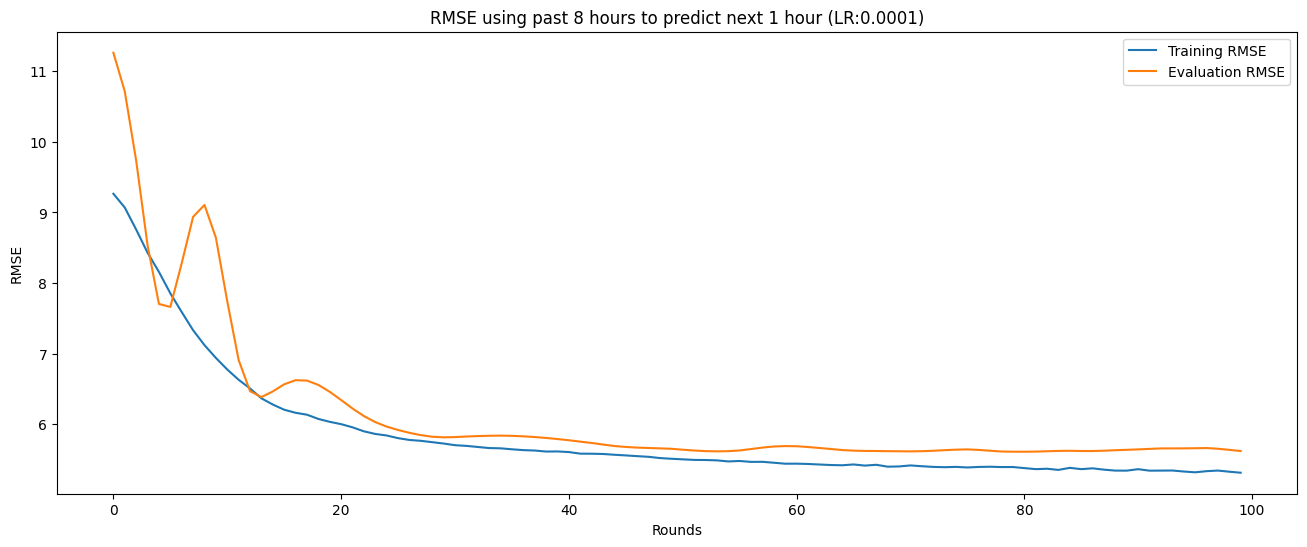

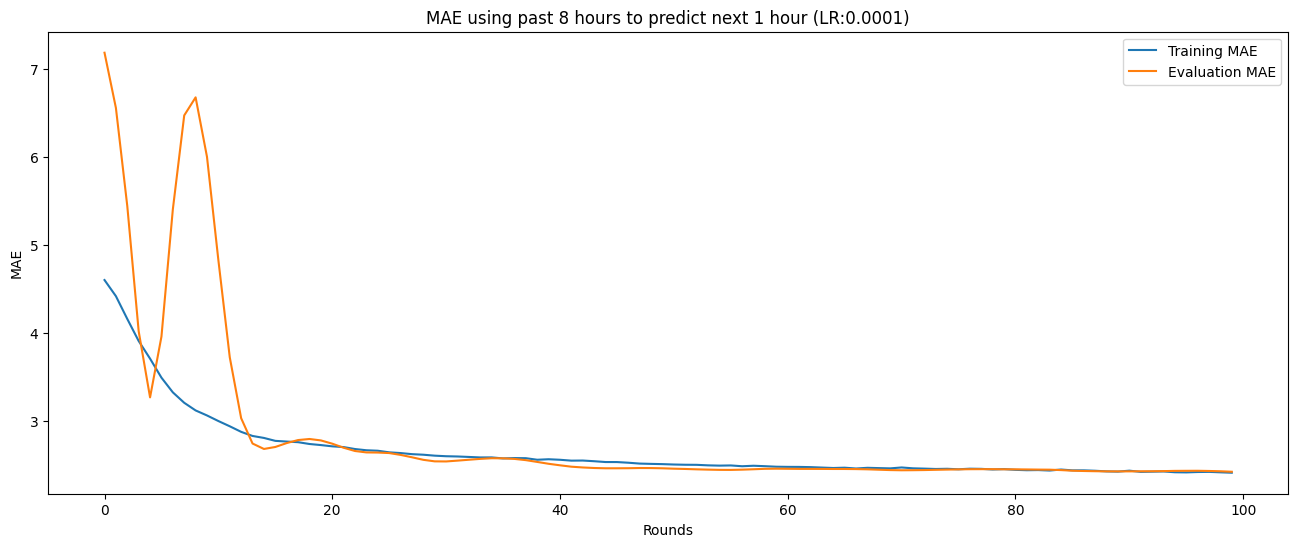

In [ ]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/public_data/past_8')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 27ms/step


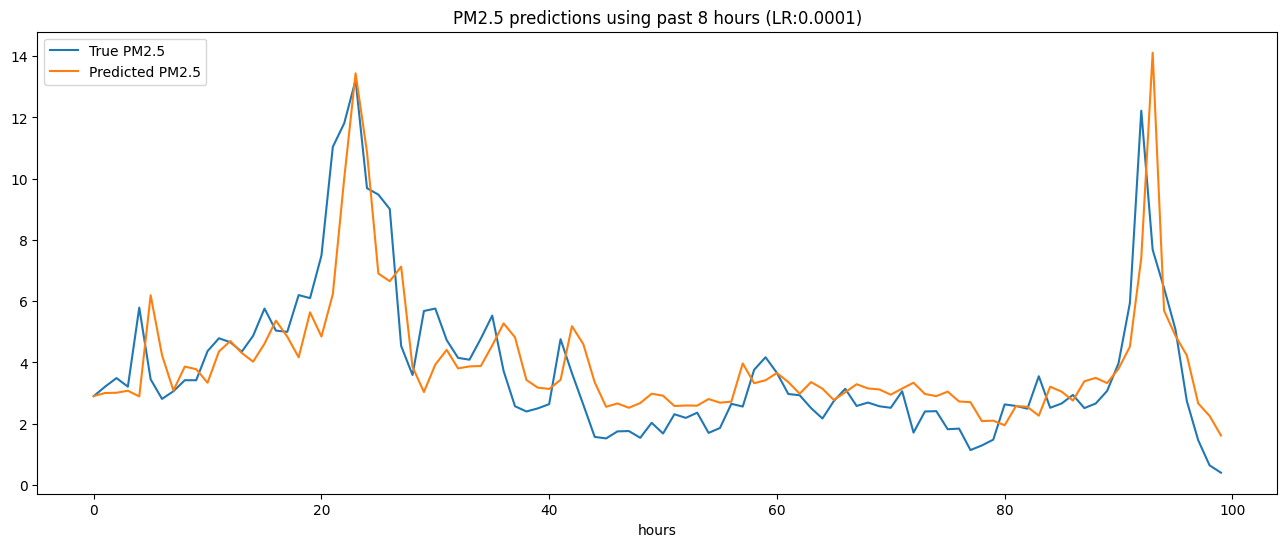

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({
    "Train Clients": [NUM_FIT, NUM_FIT],
    "Epochs": [ROUNDS, ROUNDS],
    "Server LR": ["0.001", "0.0001"],
    "Client LR": [0.1, 0.1],
    "Validation RMSE": [min(eval_acc1), min(eval_acc2)],
    "Validation MAE": [min(eval_mse1), min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.001,0.1,5.785582,2.555097
1,5,100,0.0001,0.1,5.612507,2.420787


# Past 10

In [ ]:
past = 10

x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                   train_split, past,
                                                   future, step)
x_val, y_val = multivariate_data(features_df.values, targets["pm2.5"].values,
                                               train_split, None, past,
                                               future, step)

In [ ]:
train_data = create_fl_clients(x_train, y_train, NUM_CLIENTS)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

In [ ]:
SERVER_LR = 0.001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state1, train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-15-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:8.3706 MAE:4.0148, Loss:4.0148 | Eval - RMSE:11.1076 MAE:6.9114, Loss:6.9114 | Time - 69.06
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.9219 MAE:3.7166, Loss:3.7166 | Eval - RMSE:10.2860 MAE:5.7626, Loss:5.7626 | Time - 61.71
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.5010 MAE:3.4278, Loss:3.4278 | Eval - RMSE:9.0005 MAE:4.2576, Loss:4.2576 | Time - 58.26
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:7.2322 MAE:3.2481, Loss:3.2481 | Eval - RMSE:7.7403 MAE:3.2236, Loss:3.2236 | Time - 63.83
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.9346 MAE:3.1174, Loss:3.1174 | Eval - RMSE:6.8824 MAE:2.8278, Loss:2.8278 | Time - 85.20
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:6.7932 MAE:3.0579, Loss:3.05

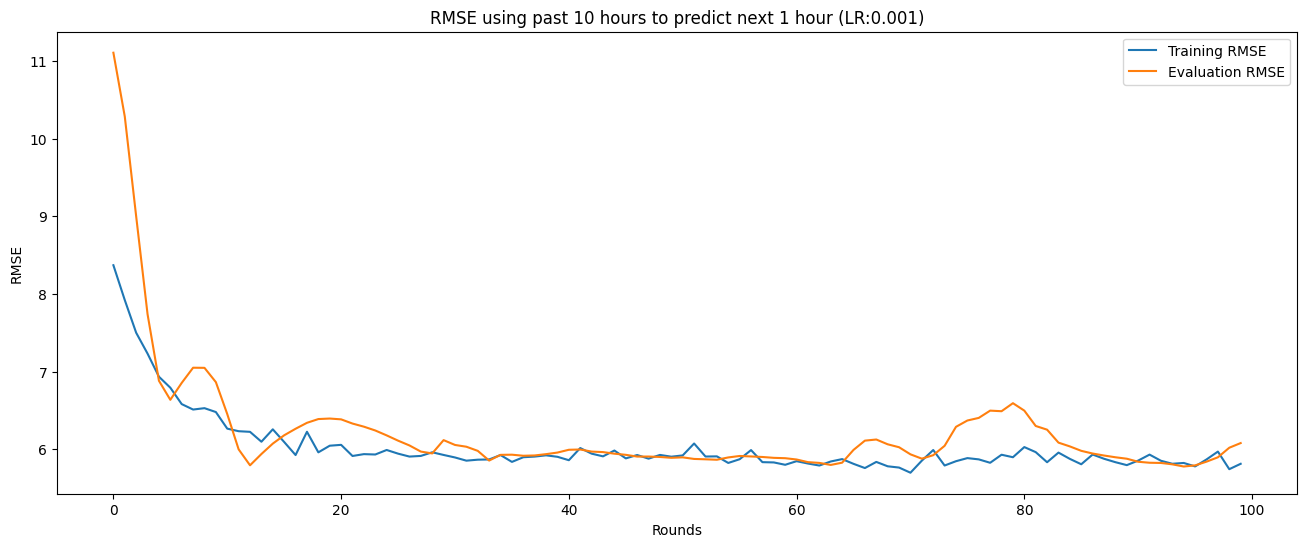

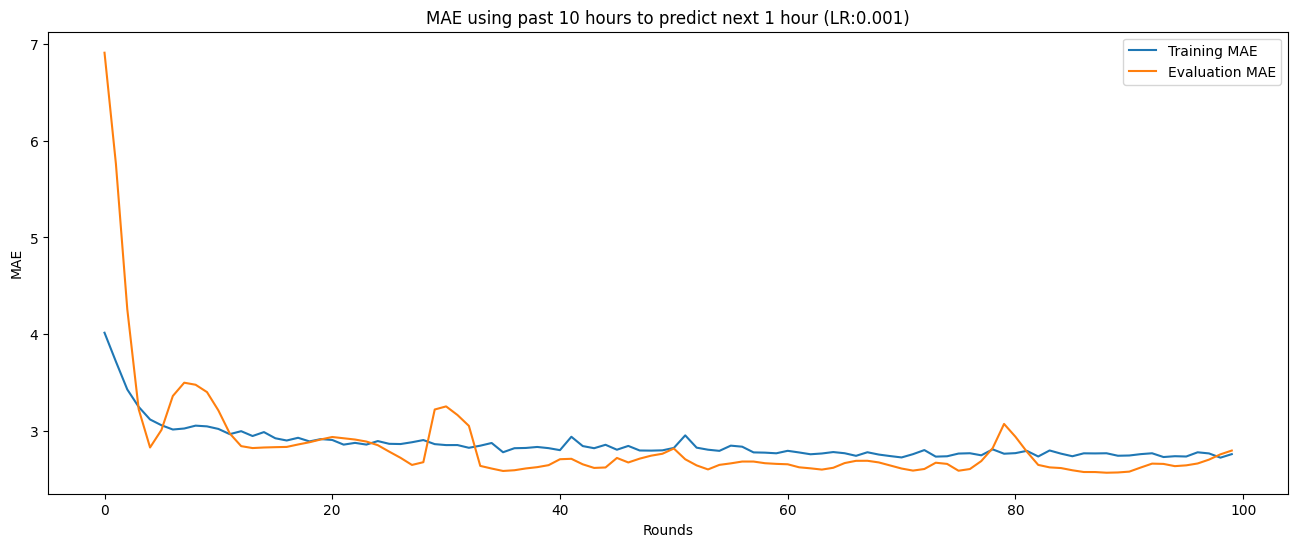

In [ ]:
plot(train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test1 = create_model_fn()
trained_model = trainer.get_model_weights(state1)
trained_model.assign_weights_to(model_test1)


predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test1.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 48ms/step


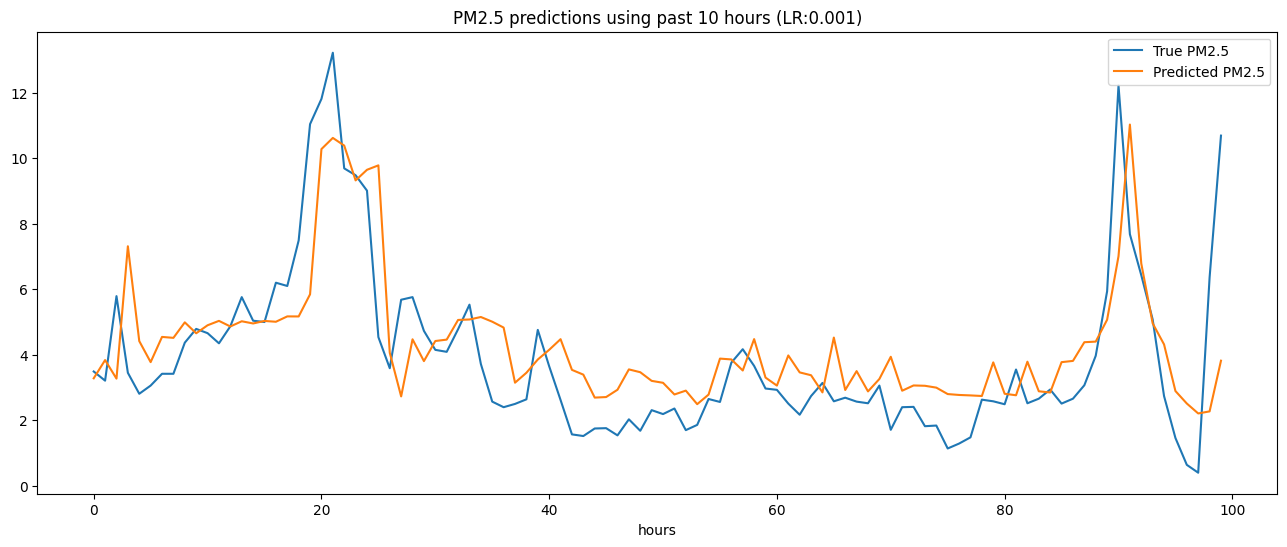

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-15-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:9.6929 MAE:4.9592, Loss:4.9592 | Eval - RMSE:11.2649 MAE:7.1017, Loss:7.1017 | Time - 58.00
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:9.4523 MAE:4.7399, Loss:4.7399 | Eval - RMSE:10.7674 MAE:6.4601, Loss:6.4601 | Time - 56.91
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:9.0818 MAE:4.4154, Loss:4.4154 | Eval - RMSE:9.8532 MAE:5.3744, Loss:5.3744 | Time - 57.82
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:8.7387 MAE:4.1469, Loss:4.1469 | Eval - RMSE:8.7503 MAE:4.0598, Loss:4.0598 | Time - 51.25
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:8.3947 MAE:3.8789, Loss:3.8789 | Eval - RMSE:7.9639 MAE:3.4338, Loss:3.4338 | Time - 56.28
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:8.0549 MAE:3.6296, Loss:3.62

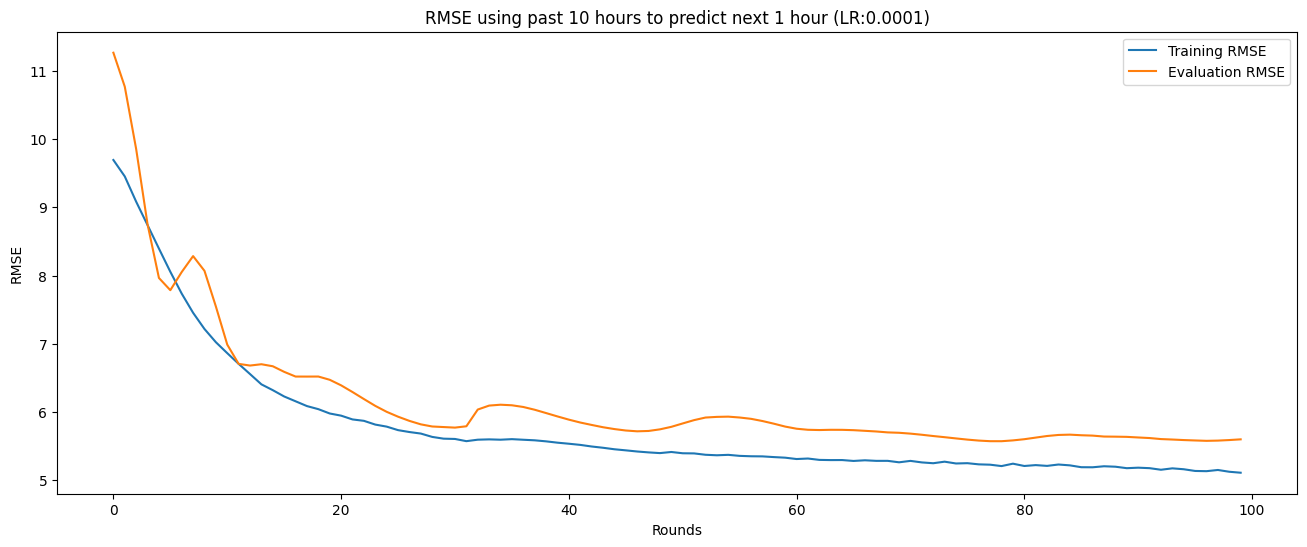

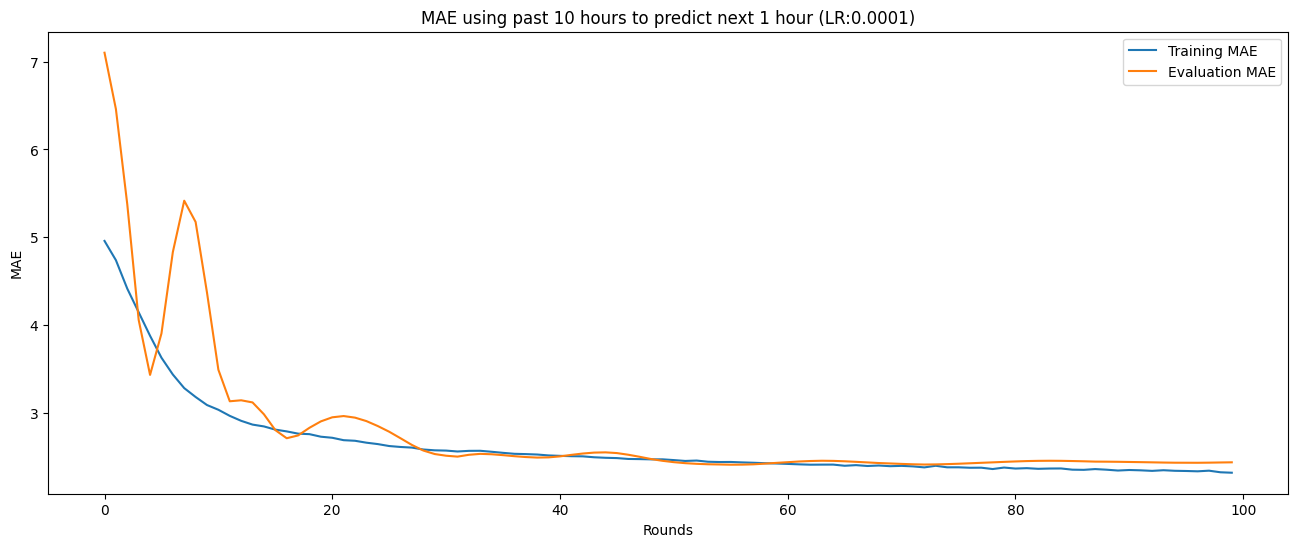

In [ ]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/public_data/past_10')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 30ms/step


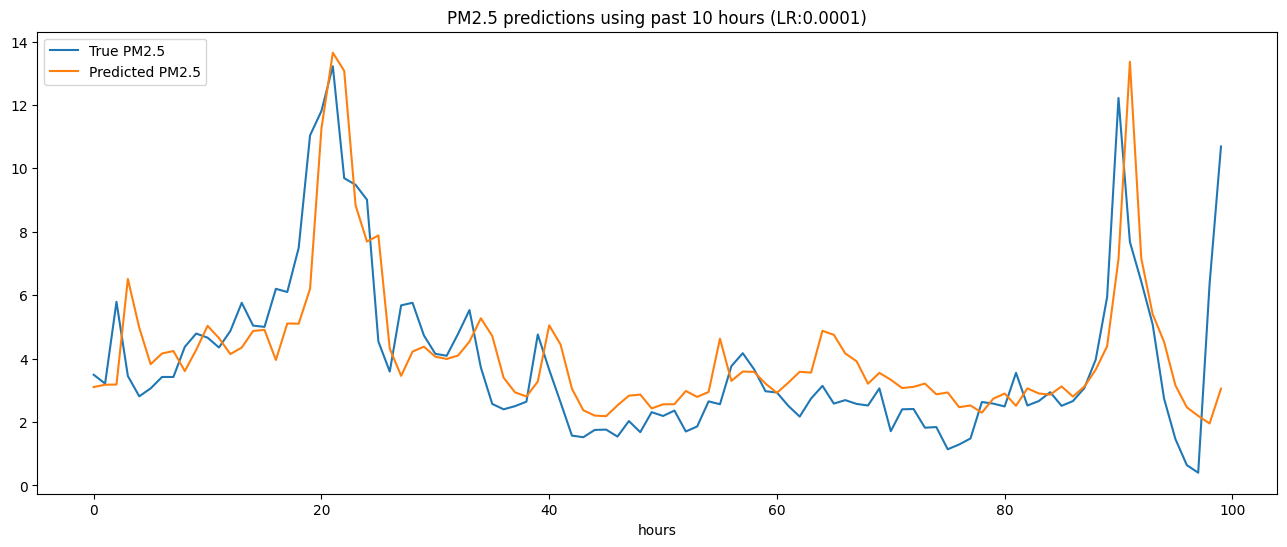

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({
    "Train Clients": [NUM_FIT, NUM_FIT],
    "Epochs": [ROUNDS, ROUNDS],
    "Server LR": ["0.001", "0.0001"],
    "Client LR": [0.1, 0.1],
    "Validation RMSE": [min(eval_acc1), min(eval_acc2)],
    "Validation MAE": [min(eval_mse1), min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.001,0.1,5.777989,2.566645
1,5,100,0.0001,0.1,5.571491,2.411387


# Past 12

In [ ]:
past = 12

x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                   train_split, past,
                                                   future, step)
x_val, y_val = multivariate_data(features_df.values, targets["pm2.5"].values,
                                               train_split, None, past,
                                               future, step)

In [ ]:
train_data = create_fl_clients(x_train, y_train, NUM_CLIENTS)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

In [ ]:
SERVER_LR = 0.001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state1, train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-15-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:8.2826 MAE:3.9459, Loss:3.9459 | Eval - RMSE:10.9578 MAE:6.6879, Loss:6.6879 | Time - 64.15
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:8.0094 MAE:3.7474, Loss:3.7474 | Eval - RMSE:10.0180 MAE:5.3828, Loss:5.3828 | Time - 69.74
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.4289 MAE:3.3579, Loss:3.3579 | Eval - RMSE:8.7277 MAE:3.9623, Loss:3.9623 | Time - 62.33
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:7.1379 MAE:3.2145, Loss:3.2145 | Eval - RMSE:7.5196 MAE:3.0474, Loss:3.0474 | Time - 58.25
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.9026 MAE:3.0996, Loss:3.0996 | Eval - RMSE:6.7600 MAE:2.7671, Loss:2.7671 | Time - 60.32
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:6.7289 MAE:3.0268, Loss:3.02

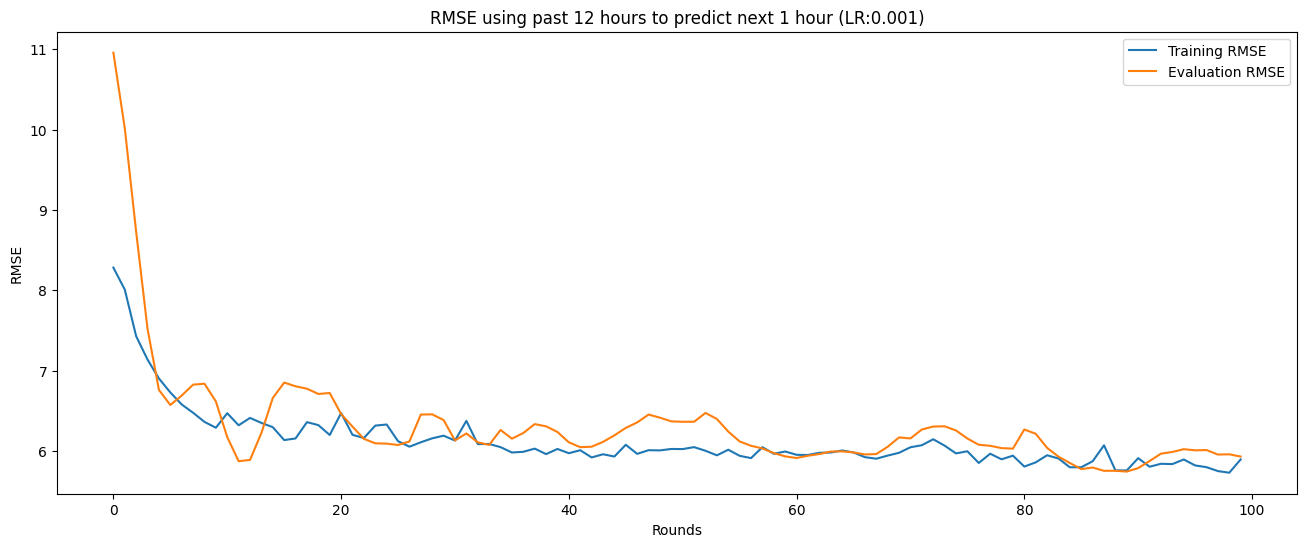

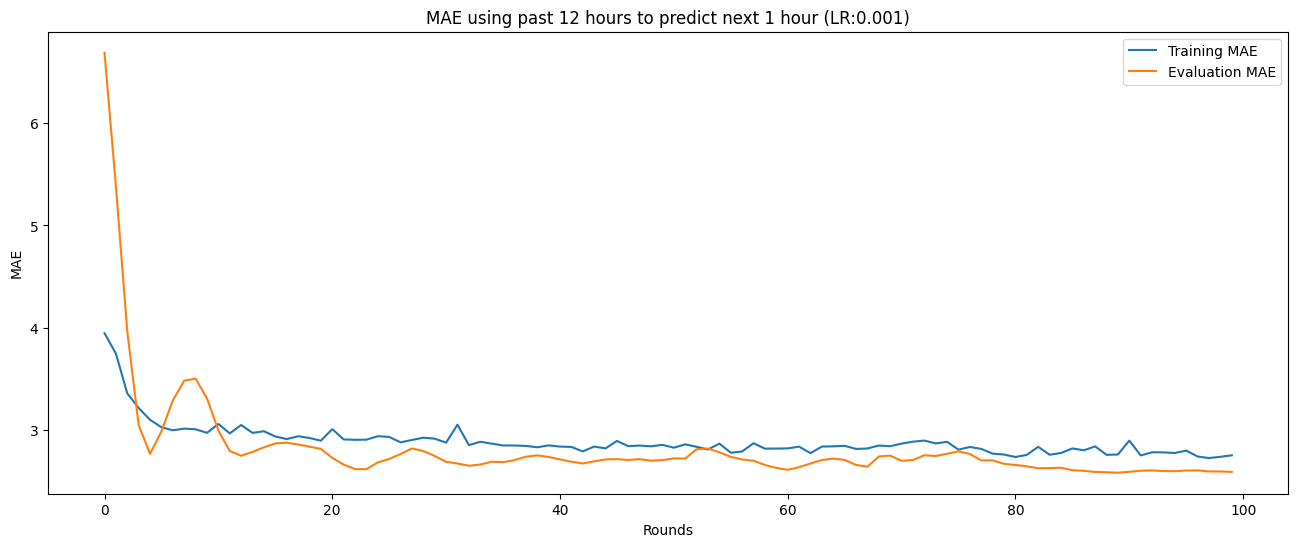

In [ ]:
plot(train_acc1, train_mse1, train_loss1, eval_acc1, eval_mse1, eval_loss1)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test1 = create_model_fn()
trained_model = trainer.get_model_weights(state1)
trained_model.assign_weights_to(model_test1)


predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test1.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 28ms/step


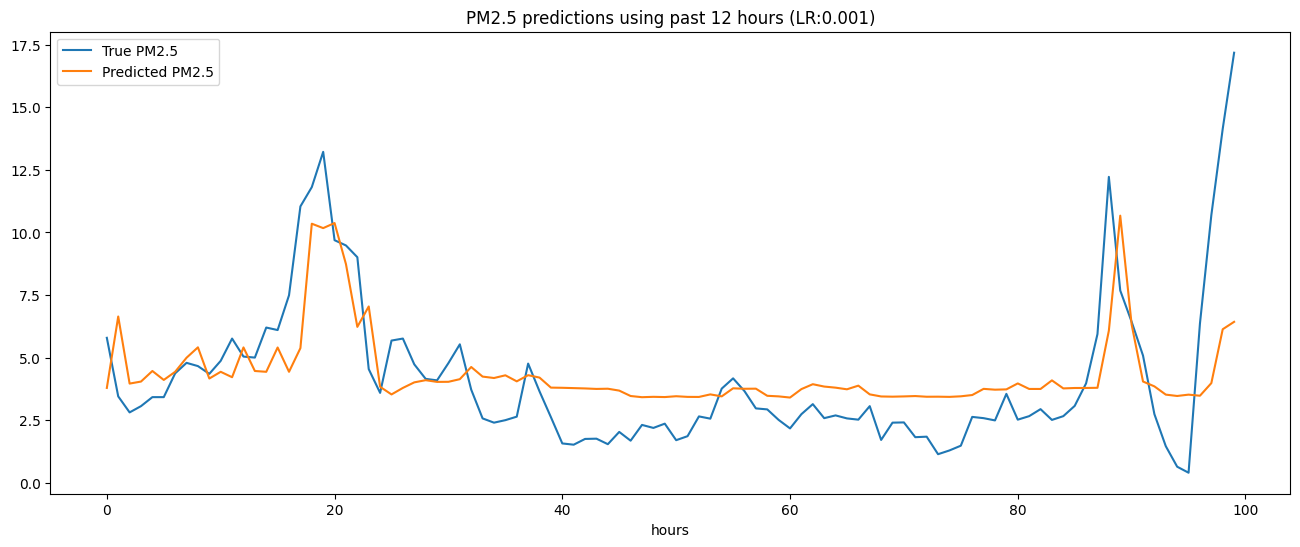

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-15-ea21928aceef>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:9.7458 MAE:5.0416, Loss:5.0416 | Eval - RMSE:11.3070 MAE:7.2280, Loss:7.2280 | Time - 73.14
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:9.5465 MAE:4.8563, Loss:4.8563 | Eval - RMSE:10.8622 MAE:6.6613, Loss:6.6613 | Time - 70.54
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:9.2539 MAE:4.5853, Loss:4.5853 | Eval - RMSE:10.0118 MAE:5.6179, Loss:5.6179 | Time - 62.60
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:8.8766 MAE:4.2528, Loss:4.2528 | Eval - RMSE:8.9354 MAE:4.2769, Loss:4.2769 | Time - 72.33
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:8.4975 MAE:3.9404, Loss:3.9404 | Eval - RMSE:8.0719 MAE:3.5026, Loss:3.5026 | Time - 76.91
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:8.1467 MAE:3.6733, Loss:3.6

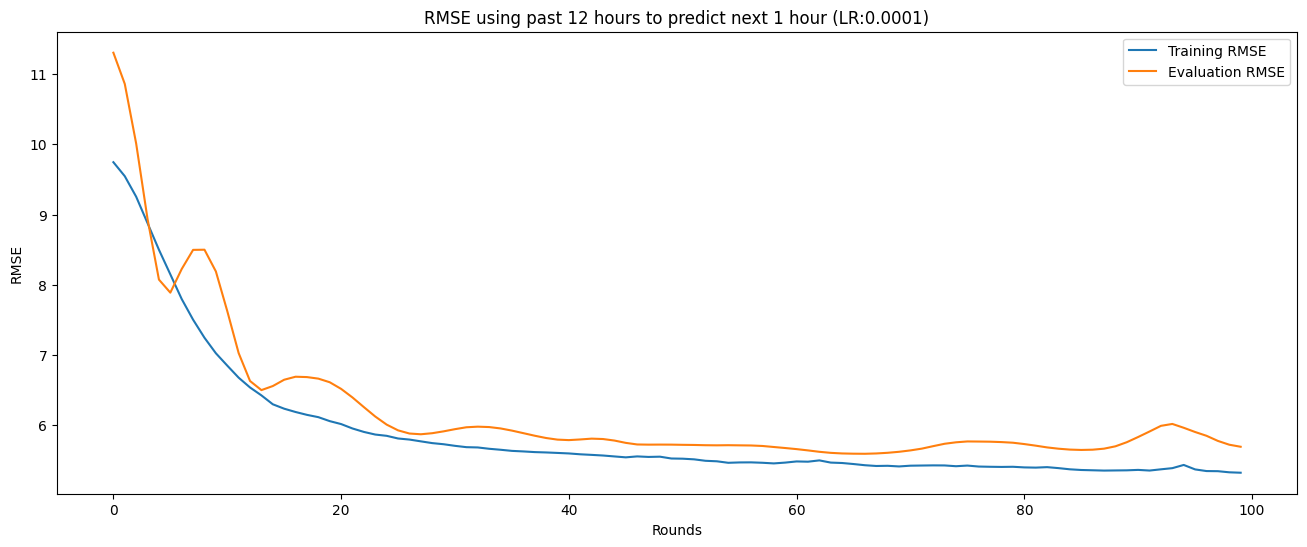

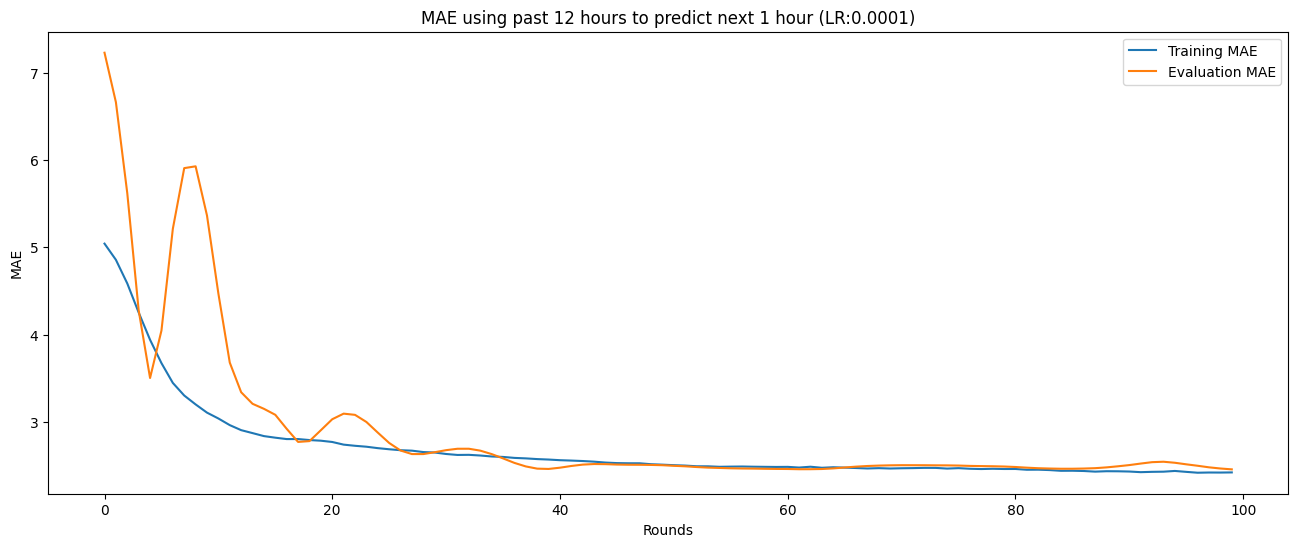

In [ ]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/public_data/past_12')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 49ms/step


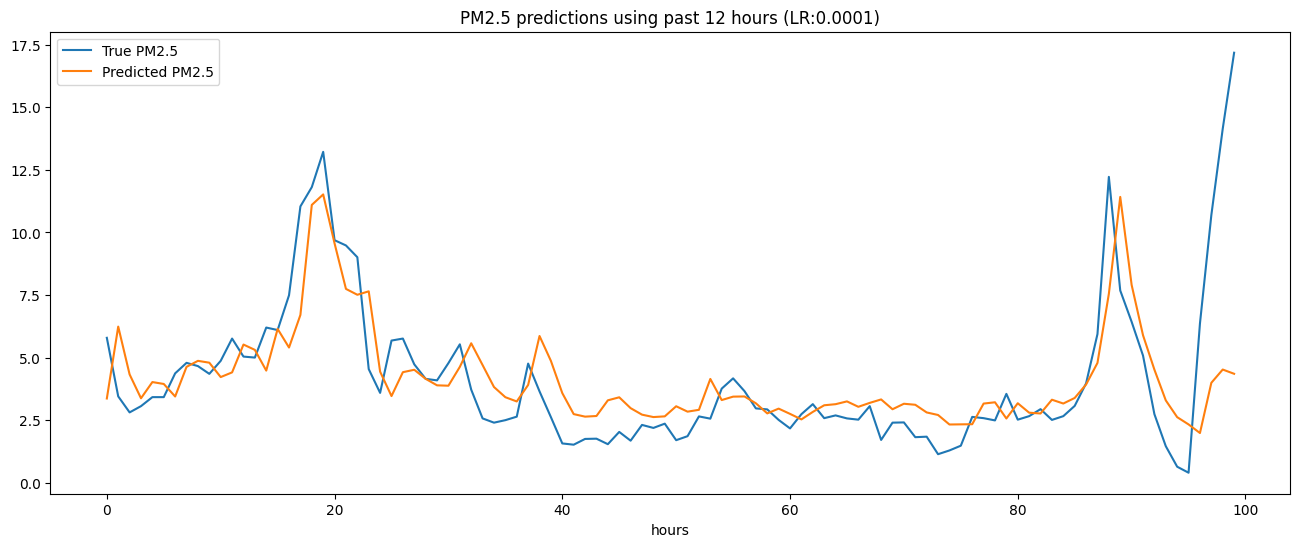

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({
    "Train Clients": [NUM_FIT, NUM_FIT],
    "Epochs": [ROUNDS, ROUNDS],
    "Server LR": ["0.001", "0.0001"],
    "Client LR": [0.1, 0.1],
    "Validation RMSE": [min(eval_acc1), min(eval_acc2)],
    "Validation MAE": [min(eval_mse1), min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.001,0.1,5.743929,2.582347
1,5,100,0.0001,0.1,5.587999,2.456496
